## Icebergs or Ships Detection Project - Kaggle 

#### *Overview* 


Drifting icebergs present threats to navigation and activities in areas such as offshore of the East Coast of Canada.

Currently, many institutions and companies use aerial reconnaissance and shore-based support to monitor environmental conditions and assess risks from icebergs. However, in remote areas with particularly harsh weather, these methods are not feasible, and the only viable monitoring option is via satellite.

Statoil, an international energy company operating worldwide, has worked closely with companies like C-CORE. C-CORE have been using satellite data for over 30 years and have built a computer vision based surveillance system. To keep operations safe and efficient, Statoil is interested in getting a fresh new perspective on how to use machine learning to more accurately detect and discriminate against threatening icebergs as early as possible.

In this competition, I was challenged to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg. Improvements made will help drive the costs down for maintaining safe working conditions.

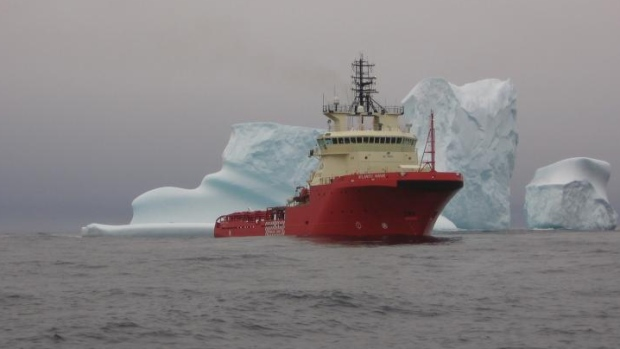

In [36]:
#Loading in required libraries 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from scipy import ndimage
from IPython.display import Image
Image(filename = "ship.jpg", width = 300, height = 300)

In [37]:
#Read in training and testing data 

train = pd.read_json('train.json')
train['inc_angle'] = pd.to_numeric(train['inc_angle'], errors = 'coerce')


In [38]:
#Let's take a look at some of the charaterisitics of our data 
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1471 non-null float64
is_iceberg    1604 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 62.7+ KB


In [39]:
#Let's take a look at our data 
train.head() 

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


##### Observations about our data 
- Four predictors and one target variable(is_iceberg)
- The 'inc_angle' feature has missing values that we might need to address later on if we decide to use that variable

In [40]:
#Splitting the training into icebergs vs ship in order to later view the images

icebergs = train[train['is_iceberg'] == 1]
ships = train[train['is_iceberg'] == 0]

### Displaying the Raw Images 

 #### *Icebergs Band 1* 
 
Band_1 and Band_2 are bascially characterized by radar backscatter produed from different polarizations at a particular incidence angle. Think of it as different photos of the same object. 

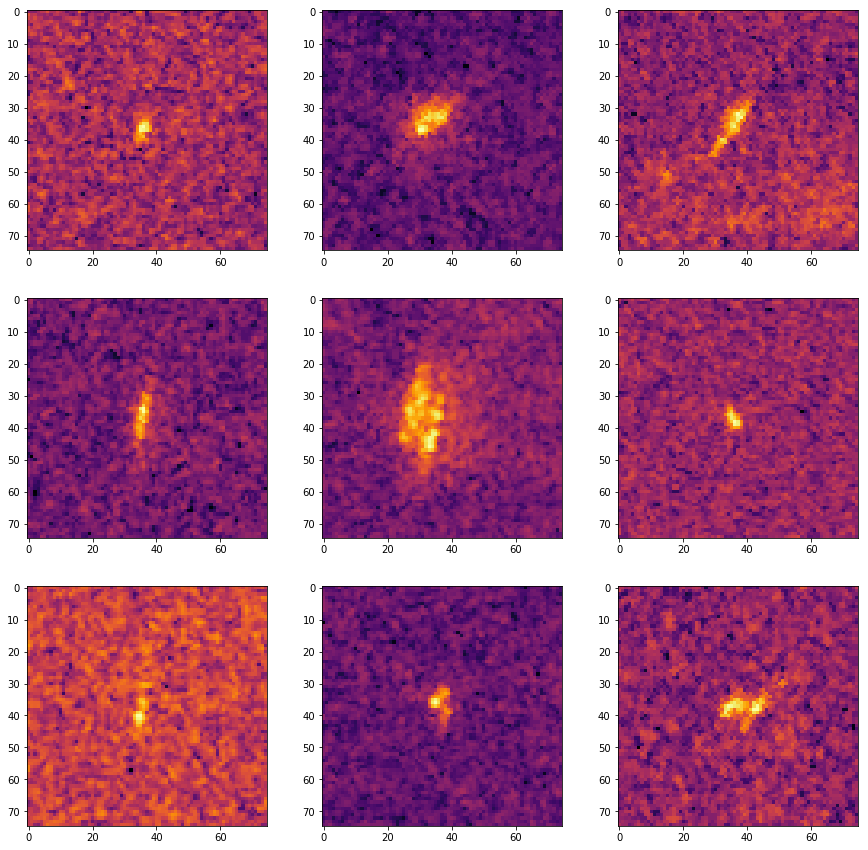

In [41]:
#Plotting Band 1 icebergs 
fig = plt.figure(1, figsize = (15,15))

for i in range(9): 
    ax = fig.add_subplot(3,3,i+1)
    array = np.reshape(np.array(icebergs.iloc[i,0]), (75,75))
    ax.imshow(array, cmap = 'inferno')
    

#### Ships Band 1 

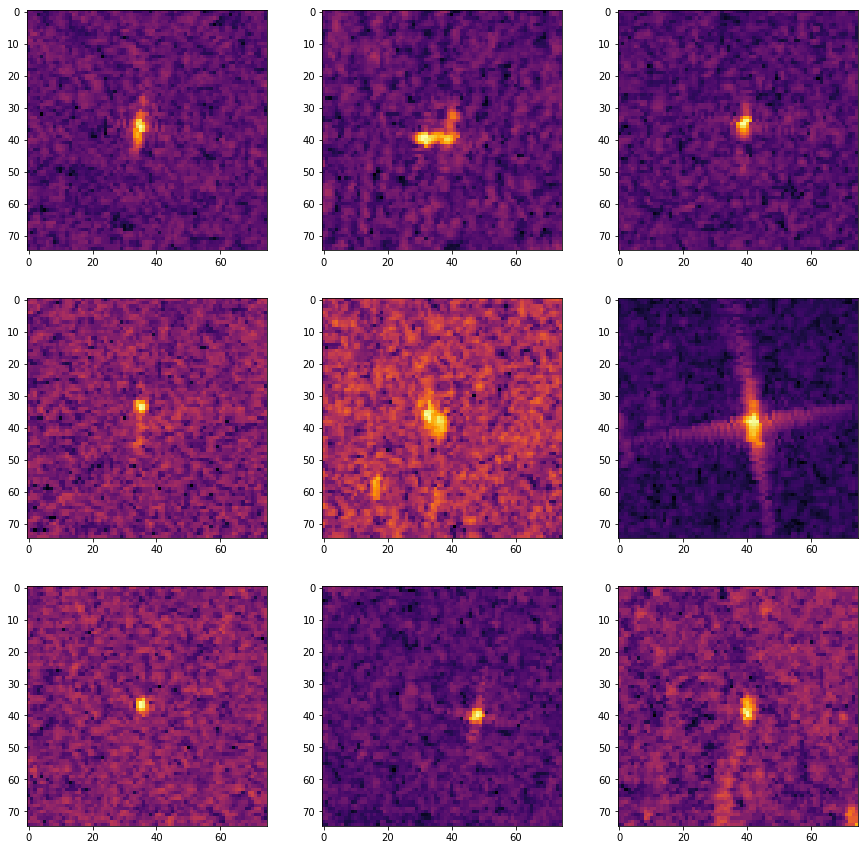

In [42]:
#Plotting Band 1 ships

fig = plt.figure(1, figsize = (15,15))

for i in range(9): 
    ax = fig.add_subplot(3,3,i+1)
    array = np.reshape(np.array(ships.iloc[i, 0]), (75,75))
    plt.imshow(array, cmap = 'inferno')

#### Icebergs Band 2 

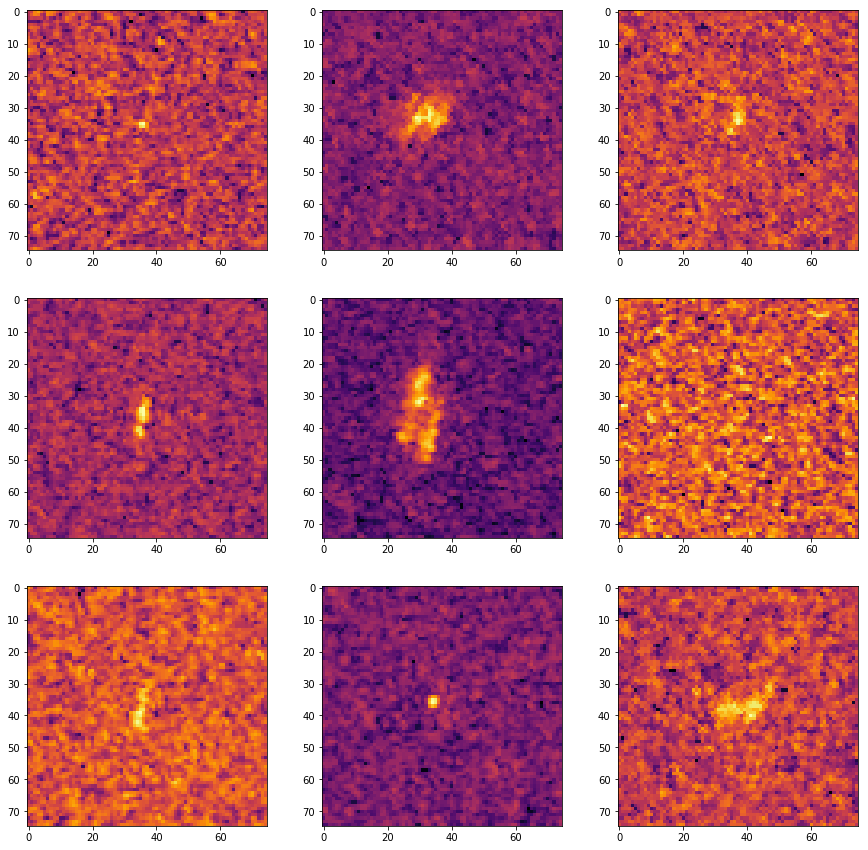

In [43]:
#Plotting Band 2 icebergs 

fig = plt.figure(1, figsize = (15,15)) 

for i in range(9): 
    ax = fig.add_subplot(3,3, i + 1)
    array = np.reshape(np.array(icebergs.iloc[i,1]), (75,75))
    plt.imshow(array, cmap = 'inferno' )

#### Ships Band 2 

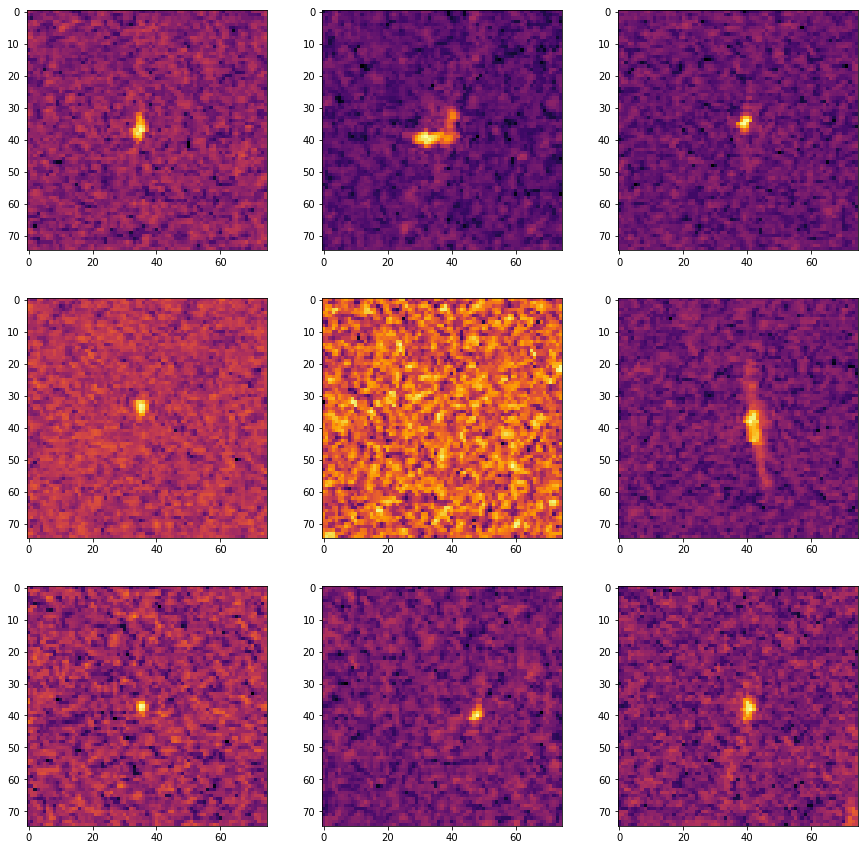

In [44]:
#Plotting Band 1 ships 

fig = plt.figure(1, figsize = (15,15))

for i in range(9): 
    ax = fig.add_subplot(3,3, i+1)
    array = np.reshape(np.array(ships.iloc[i,1]), (75,75))
    plt.imshow(array, cmap = 'inferno')

### Image Preprocessing 

In [45]:
#Reshape and feature scale the images

def scale_images(df): 
    images = [] 
    
    for i, row in df.iterrows(): 
        band_1 = np.array(row['band_1']).reshape(75,75)
        band_2 = np.array(row['band_2']).reshape(75,75)
        band_3 = band_1 + band_2 
        
        #Rescale 
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())
        
        images.append(np.dstack((a,b,c))) #numpy.dstack takes a sequence of arrays and stacks them along third axis 
        
    return np.array(images)

In [46]:
X_train = scale_images(train) 
X_train.shape

(1604, 75, 75, 3)

For clarity, the shape forllowing image format (samples, height, width, channels). We have created another channel by adding together the bands to establish band 3. 

In [47]:
#Get target variable 

Y_train = np.array(train['is_iceberg'])

### Building CNN using Keras 

In [48]:
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [53]:
#Create our model 

def model(): 
    
    model = Sequential() 
    
    #Building our model 
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))
    
    #Conv Layer 2 
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))
    
     #Conv Layer 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #Conv Layer 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))
    
    #Flatten the data for upcoming dense layers 
    model.add(Flatten())
    
    #Dense Layer 
    
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2)) 
    
    #Dense Layer 2 
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    
    #Sigmoid Output 
    
    model.add(Dense(output_dim = 1, activation = 'sigmoid'))
    
    
    
    optimizer = Adam(lr = 0.001, decay = 0.0)

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary() 
    
    return model 

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)                                                                                 
        

In [54]:
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

In [ ]:
#Without denoising, core features.
import os
gmodel= model()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

C:\Users\Siddarth\Anaconda_main\lib\site-packages\ipykernel\__main__.py:44: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 15, 15, 128)       147584    
__________